In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm
from tqdm import tqdm
from functions import (
    SimulateRateManager,
    SolverRateManager,
    EigenvectorRateManager,
    get_eq_times,
)
from setup import setup_matplotlib

setup_matplotlib()

np.random.seed(42)

In [3]:
version = 2

k = 1
border = 0
x_0 = -1
N_x_border = 12.5  # 24.5
max_t = 10
ntau = 2
force = "cusp_force"
# absorbing = True


dx = (border - x_0) / N_x_border
sb = 40.5 * dx  #  80.5 * dx #with .5, 0 not included


f = 15
N_p = 2_000
N_loop = 10

eq_perc = 0.75
eq_f = 0.75
q_f = np.log(1 - eq_f) / np.log(1 - eq_perc)

ntau_sim = ntau * f


# x_s = np.arange(-sb, sb + 1e-6, dx)
# i_zero = np.argmin((x_s - x_0) ** 2)
# N_x = len(x_s)

s_s = np.arange(0.2, 0.81, 0.1)
# s_s = np.array([0.3])
# ltaus = np.array([0.1])
ltaus = np.concatenate(([0, 0.05], np.arange(0.2, np.pi / 2, 0.2)))

In [4]:
def get_sim_rates(
    s_s, ltaus, N_p, N_loop, max_t, ntau_sim, x_0, force, border, q_f, absorbing
):
    sim_rate = np.empty((len(s_s), len(ltaus), 4), float)
    my_rate_manager = SimulateRateManager()

    for j, s in enumerate(tqdm(s_s)):
        D = s**2 / 2

        for i, ltau in enumerate(ltaus):
            ldt = ltau / ntau_sim if ltau > 0 else ltaus[1] / ntau_sim
            rel_time = q_f * get_eq_times(ltau, D, eq_perc, a=0, b=1)
            N_t = max(int(2 * rel_time / ldt), int(max_t / ldt), 30)

            sim_ts = (
                np.arange(-ntau_sim, N_t) * ldt if ltau > 0 else np.arange(0, N_t) * ldt
            )

            res = my_rate_manager.run(
                N_p=N_p,
                N_loop=N_loop,
                N_t=N_t,
                ntau=ntau_sim if ltau > 0 else 0,
                s=s,
                dt=ldt,
                x_0=x_0,
                force=force,
                border=border,
                absorbing=absorbing,
            )
            if absorbing:
                sim_sur = res["sim_sur"]
            else:
                sim_sur = 2 * res["sim_sur"] - 1

            sim_cond = (sim_ts > rel_time) * (sim_sur > 0.05)
            sim_rates = [
                -np.mean(np.diff(np.log(sim_sur[i, this_sim_cond])) / ldt)
                for i, this_sim_cond in enumerate(sim_cond)
            ]

            mean_sim_rates = np.mean(sim_rates, axis=0)
            sim_rate[j, i] = (
                np.mean(sim_rates),
                np.std(sim_rates) / np.sqrt(N_loop),
                np.min(mean_sim_rates),
                np.max(mean_sim_rates),
            )
    return sim_rate


def get_num_rate(
    s_s, ltaus, max_t, N_x, sbs, ntau, x_0, force, border, q_f, absorbing, version
):
    num_rate = np.empty((len(s_s), len(ltaus), 4), float)
    my_solver_rate_manager = SolverRateManager()

    for j, s in enumerate(tqdm(s_s)):
        D = s**2 / 2

        for i, ltau in enumerate(ltaus):
            ldt = ltau / ntau if ltau > 0 else ltaus[1] / ntau
            rel_time = q_f * get_eq_times(ltau, D, eq_perc, a=0, b=1)
            N_t = max(int(2 * rel_time / ldt), int(max_t / ldt), 30)

            ts = np.arange(0, N_t) * ldt

            res = my_solver_rate_manager.run(
                N_t=N_t,
                N_x=N_x,
                sbs=sbs,
                ntau=ntau if ltau > 0 else 0,
                s=s,
                dt=ldt,
                x_0=x_0,
                force=force,
                border=border,
                absorbing=absorbing,
                version=version,
            )
            if absorbing:
                num_sur = res["num_sur"]
            else:
                num_sur = 2 * res["num_sur"] - 1

            num_cond = (ts > rel_time) * (num_sur > 0.05)
            num_rates = -np.mean(np.diff(np.log(num_sur[num_cond])) / ldt)
            num_rate[j, i] = (
                np.mean(num_rates),
                0,
                np.min(num_rates),
                np.max(num_rates),
            )
    return num_rate


def get_num_rate_st(
    s_s, ltaus, max_t, N_x, sbs, ntau, x_0, force, border, q_f, absorbing, version
):
    num_rate = np.empty((len(s_s), len(ltaus), 4), float)
    my_solver_rate_manager = SolverRateManager()

    for j, s in enumerate(tqdm(s_s)):
        for i, ltau in enumerate(ltaus):
            ldt = ltau / ntau if ltau > 0 else ltaus[1] / ntau

            ldt_a = ldt * (1 + ltau)
            max_t_a = (1 + ltau) * max_t
            s_a = s * (1 + ltau)
            D_a = s_a**2 / 2

            rel_time = q_f * get_eq_times(0, D_a, eq_perc, a=0, b=1)
            N_t = max(
                int(2 * rel_time / ldt_a), int(max_t_a / ldt_a), int(30 * (1 + ltau))
            )

            ts = np.arange(0, N_t) * ldt_a

            res = my_solver_rate_manager.run(
                N_t=N_t,
                N_x=N_x,
                sbs=sbs,
                ntau=0,
                s=s_a,
                dt=ldt_a,
                x_0=x_0,
                force=force,
                border=border,
                absorbing=absorbing,
                version=version,
            )
            if absorbing:
                num_sur = res["num_sur"]
            else:
                num_sur = 2 * res["num_sur"] - 1

            num_cond = (ts > rel_time) * (num_sur > 0.05)
            num_rates = (
                -np.mean(np.diff(np.log(num_sur[num_cond])) / ldt_a) * 1 / (1 + ltau)
            )
            num_rate[j, i] = (
                np.mean(num_rates),
                0,
                np.min(num_rates),
                np.max(num_rates),
            )
    return num_rate


def get_eig_rate(s_s, ltaus, N_x, sbs, ntau, force, version):
    eig_rate = np.zeros((len(s_s), len(ltaus)), float)
    my_eigen_rate_manager = EigenvectorRateManager()

    for j, s in enumerate(tqdm(s_s)):
        for i, ltau in enumerate(ltaus):
            ldt = ltau / ntau if ltau > 0 else ltaus[1] / ntau
            #  N_x, sb, ntau, s, dt, force, version
            res = my_eigen_rate_manager.run(
                N_x=N_x,
                sbs=sbs,
                ntau=ntau if ltau > 0 else 0,
                s=s,
                dt=ldt,
                force=force,
                version=version,
            )

            eig_rate[j, i] = res["eig_rate"]
    return eig_rate

In [5]:
both_sim_rate = []
both_num_rate = []
both_num_rate_st = []
for absorbing in [False, True]:
    if absorbing:
        N_x = int((border + sb) / dx)
        sbs = [-sb, border - dx / 2]
    else:
        N_x = int((2 * sb) / dx) + 1
        sbs = [-sb, sb]

    both_sim_rate.append(
        get_sim_rates(
            s_s, ltaus, N_p, N_loop, max_t, ntau_sim, x_0, force, border, q_f, absorbing
        )
    )
    both_num_rate.append(
        get_num_rate(
            s_s,
            ltaus,
            max_t,
            N_x,
            sbs,
            ntau,
            x_0,
            force,
            border,
            q_f,
            absorbing,
            version,
        )
    )
    both_num_rate_st.append(
        get_num_rate_st(
            s_s,
            ltaus,
            max_t,
            N_x,
            sbs,
            ntau,
            x_0,
            force,
            border,
            q_f,
            absorbing,
            version,
        )
    )
    if absorbing:
        eig_rate = get_eig_rate(s_s, ltaus, N_x, sbs, ntau, force, version)

  0%|          | 0/7 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 34.42it/s]/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_19594/1526687361.py:163: ComplexWarning: Casting complex values to real discards the imaginary part
  eig_rate[j, i] = res["eig_rate"]
100%|██████████| 7/7 [00:00<00:00, 183.24it/s]


In [39]:
# Kramers
k_t = np.cos(ltaus) / (1 + np.sin(ltaus))  # new stiffness
D_t = (s_s**2) / 2
kramers = (
    1 / (2 * np.pi) * k_t[None, :] * np.exp(-k_t[None, :] * 1**2 / (2 * D_t[:, None]))
)
new_kramers = (
    1
    / (np.sqrt(2 * np.pi * D_t[:, None]))
    * k_t[None, :] ** (3 / 2) * 1
    * np.exp(-k_t[None, :] * 1**2 / (2 * D_t[:, None]))
)

# Visualtisation

In [40]:
absorbing = True
sim_rate = both_sim_rate[1]
num_rate = both_num_rate[1]
num_rate_st = both_num_rate_st[1]

# absorbing = False
# sim_rate = both_sim_rate[0]
# num_rate = both_num_rate[0]
# num_rate_st = both_num_rate_st[0]

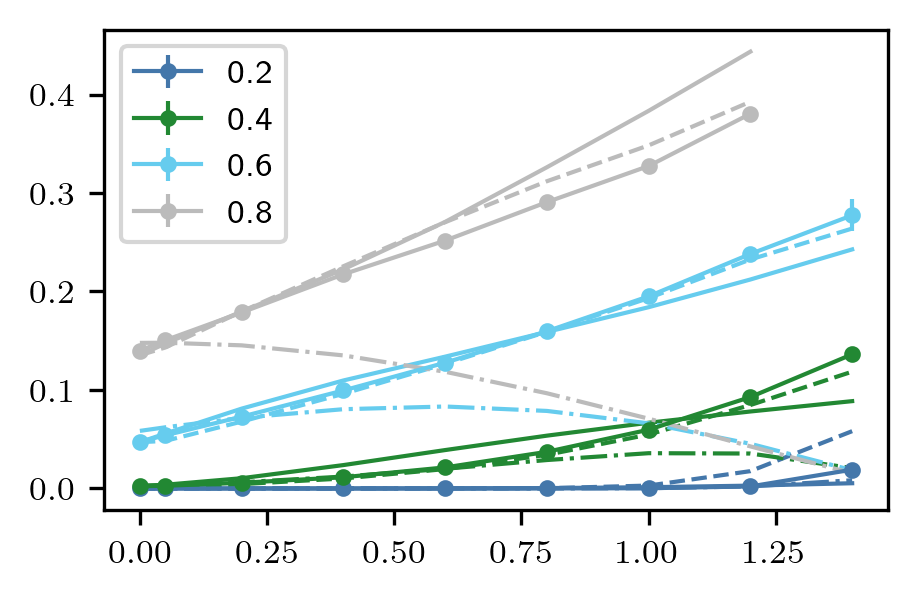

In [47]:
for i in range(0, len(s_s), 2):
    plt.errorbar(
        ltaus,
        sim_rate[i, :, 0],
        sim_rate[i, :, 1],
        marker=".",
        color=f"C{i}",
        label=round(s_s[i], 2),
    )
    plt.plot(ltaus, num_rate[i, :, 0], ls="--", color=f"C{i}")
    plt.plot(ltaus, num_rate_st[i, :, 0], ls="-", color=f"C{i}")
    plt.plot(ltaus, new_kramers[i, :], ls="-.", color=f"C{i}")
    # if absorbing:
    #     plt.plot(ltaus, eig_rate[i, :], ls="-.", color=f"C{i}")
plt.legend()
#plt.yscale('log')

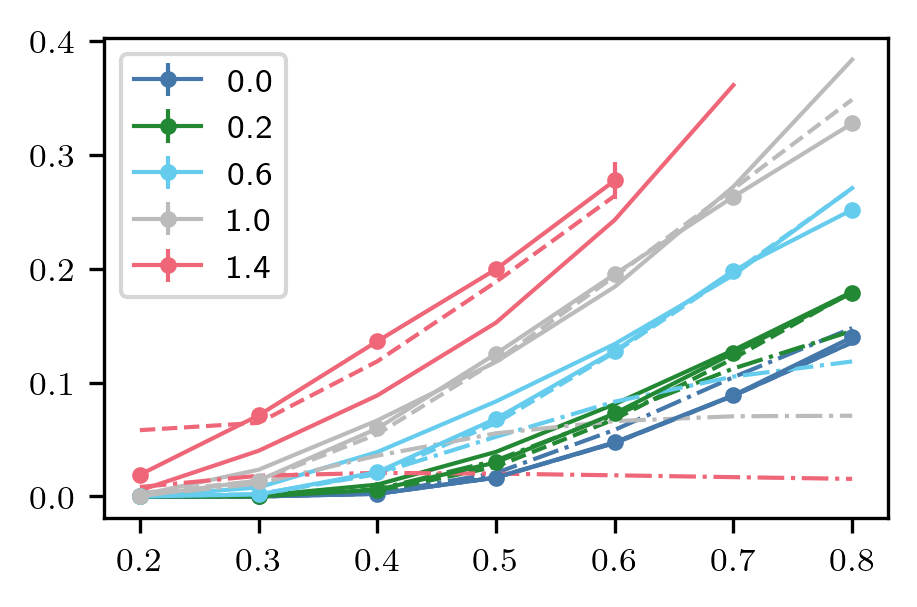

In [49]:
for i in range(0, len(ltaus), 2):
    plt.errorbar(
        s_s,
        sim_rate[:, i, 0],
        sim_rate[:, i, 1],
        marker=".",
        color=f"C{i}",
        label=round(ltaus[i], 2),
    )
    plt.plot(s_s, num_rate[:, i, 0], ls="--", color=f"C{i}")
    plt.plot(s_s, num_rate_st[:, i, 0], ls="-", color=f"C{i}")
    plt.plot(s_s, new_kramers[:,i], ls="-.", color=f"C{i}")
    # if absorbing:
    #     plt.plot(s_s, eig_rate[:, i], ls="-.", color=f"C{i}")
plt.legend()
# plt.yscale('log')
# plt.ylim(1e-3, 1e0)

0.4000000000000001


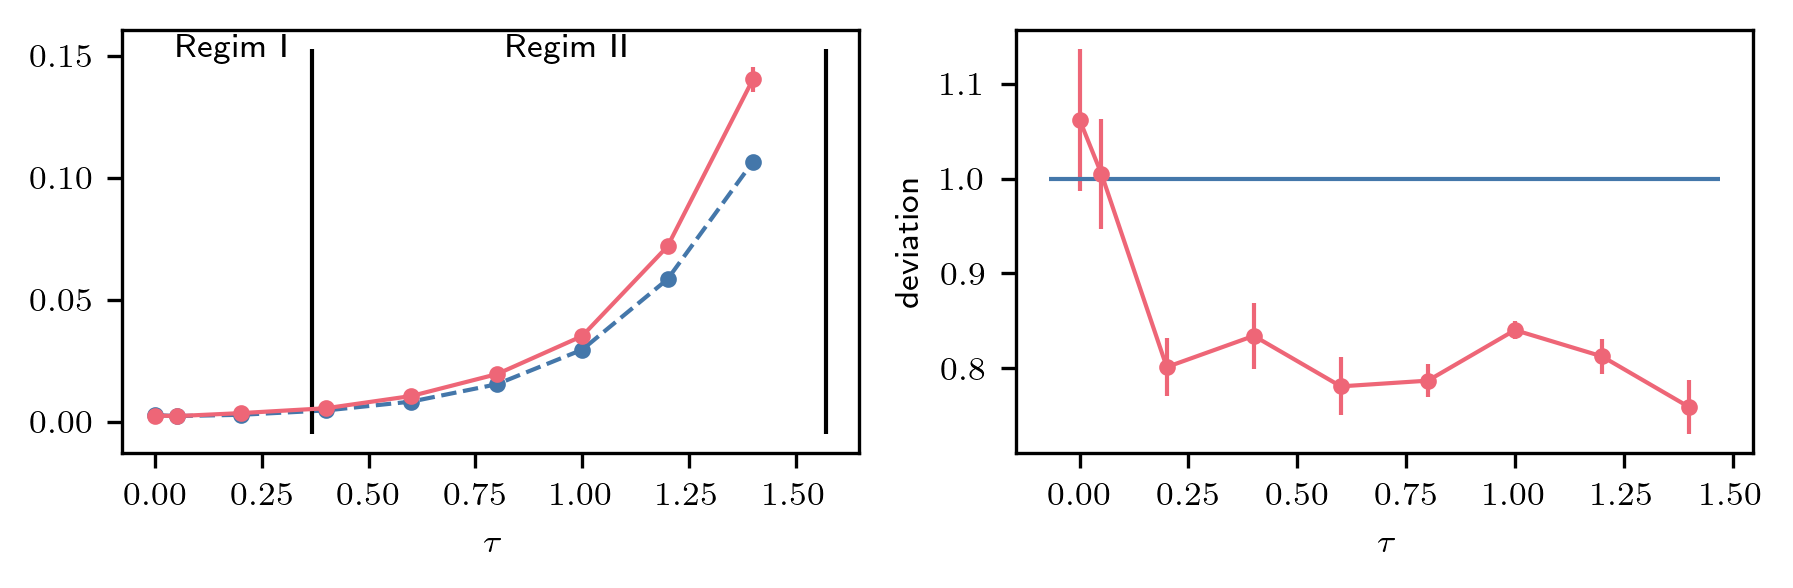

In [17]:
idx = 2
print(s_s[idx])

plt.figure(figsize=(6, 2))
plt.subplot(121)
plt.plot(ltaus, num_rate[idx, :, 0], ".--")
plt.errorbar(ltaus, sim_rate[idx, :, 0], sim_rate[idx, :, 1], marker=".")


# plt.xlim(0,2.1)
# plt.ylim(1e-3,1)

plt.vlines([1 / np.e / k, np.pi / 2 / k], *plt.ylim(), color="black")

y = 0.95 * plt.ylim()[1]
plt.text(0.5 * 1 / np.e / k, y, "Regim I", ha="center", va="center")
plt.text(0.5 * (1 / np.e / k + np.pi / 2 / k), y, "Regim II", ha="center", va="center")
# plt.text(
#     0.5 * (np.pi / 2 / k + plt.xlim()[1]), y, "Regim III", ha="center", va="center"
# )
plt.xlabel(r"$\tau$")
# plt.ylabel('1/rate')
# plt.yscale('log')

plt.subplot(122)

# plt.plot(ltaus, num_rate[idx,:, 0] / sim_rate[idx,:, 0])
plt.errorbar(
    ltaus,
    num_rate[idx, :, 0] / sim_rate[idx, :, 0],
    yerr=np.sqrt(
        (num_rate[idx, :, 1] / sim_rate[idx, :, 0]) ** 2
        + (num_rate[idx, :, 0] / sim_rate[idx, :, 0] ** 2 * sim_rate[idx, :, 1]) ** 2
    ),
    marker=".",
    color="C1",
)
plt.hlines(1, *plt.xlim())
plt.xlabel(r"$\tau$")
plt.ylabel("deviation")
plt.tight_layout()
# plt.savefig(f'graphics/cusp_rates_s{s}.pdf')

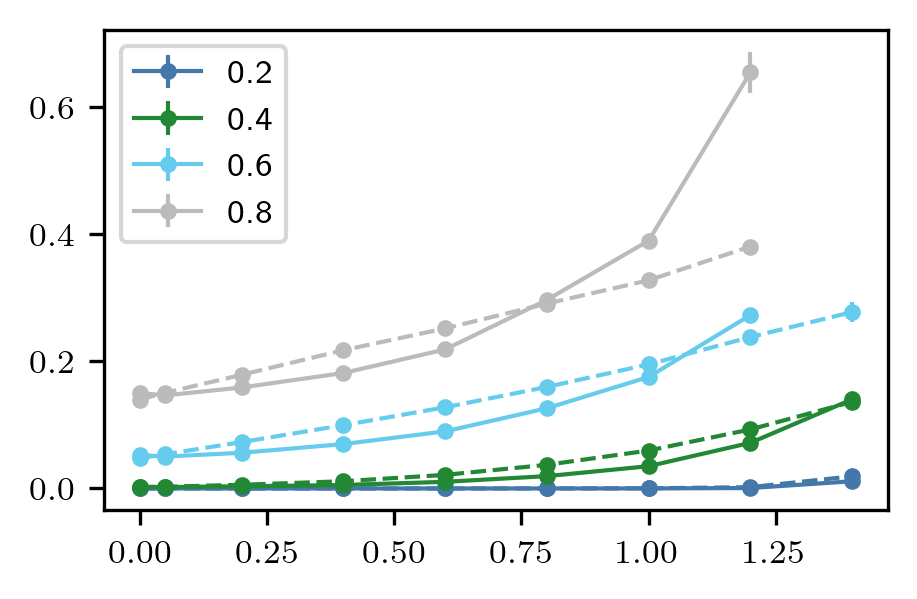

In [11]:
for i in range(0, len(s_s), 2):
    plt.errorbar(
        ltaus,
        both_sim_rate[0][i, :, 0],
        both_sim_rate[0][i, :, 1],
        marker=".",
        color=f"C{i}",
        label=round(s_s[i], 2),
    )
    plt.errorbar(
        ltaus,
        both_sim_rate[1][i, :, 0],
        both_sim_rate[1][i, :, 1],
        marker=".",
        ls="--",
        color=f"C{i}",
    )
plt.legend()

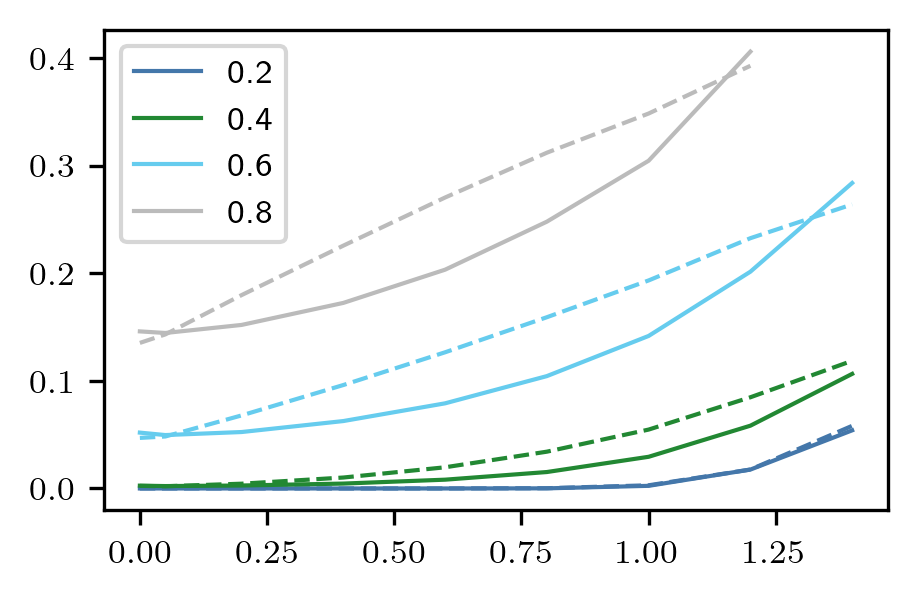

In [12]:
for i in range(0, len(s_s), 2):
    plt.plot(
        ltaus, both_num_rate[0][i, :, 0], ls="-", color=f"C{i}", label=round(s_s[i], 2)
    )
    plt.plot(ltaus, both_num_rate[1][i, :, 0], ls="--", color=f"C{i}")
plt.legend()
# plt.yscale('log')

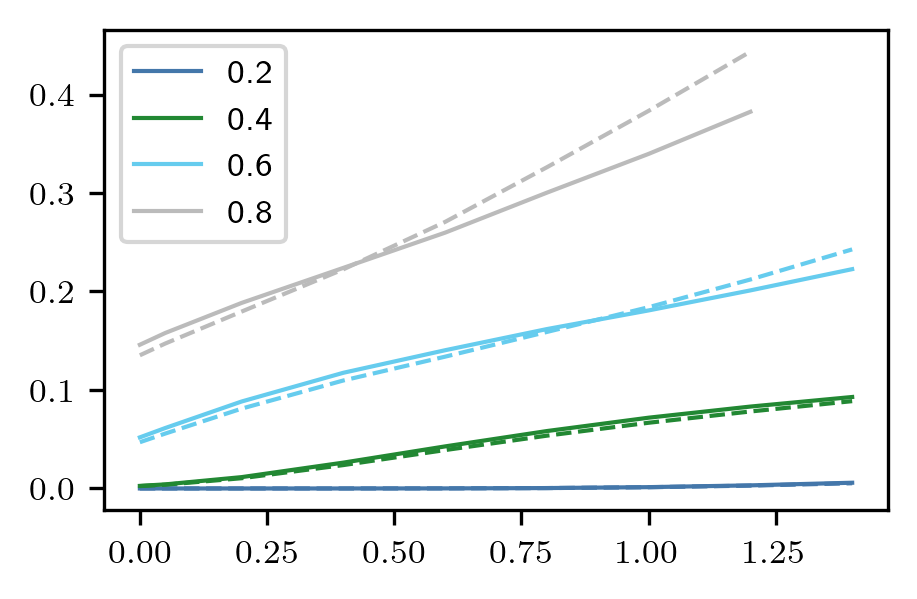

In [14]:
for i in range(0, len(s_s), 2):
    plt.plot(
        ltaus,
        both_num_rate_st[0][i, :, 0],
        ls="-",
        color=f"C{i}",
        label=round(s_s[i], 2),
    )
    plt.plot(ltaus, both_num_rate_st[1][i, :, 0], ls="--", color=f"C{i}")
plt.legend()
# plt.yscale('log')